In [1]:
import torch
from model.model_vae_no_sig import CVAE, cvae_loss ## 따로 sigmoid 진행하지 않았음
from vae_earlystopping import EarlyStopping
import numpy as np
import joblib
import pandas as pd

In [2]:
train_loader = torch.load('torch/train_loader_z.pt')
val_loader = torch.load('torch/val_loader_z.pt')
test_loader = torch.load('torch/test_loader_z.pt')

C:\Users\User\AppData\Local\Temp\ipykernel_11324\1651108954.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load('torch/train_loader_z.pt')
C:\Users

In [3]:
x,c = next(iter(train_loader))
x_dim = x.shape[1]
c_dim = c.shape[1]
print(x_dim,c_dim)

23 9


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CVAE(x_dim=x_dim,c_dim = c_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)

In [5]:
epochs = 500
loss_names = ["loss1", "loss2", "loss3", "loss4"]

train_losses = [[] for _ in range(4)]
val_losses   = [[] for _ in range(4)]
train_recones = [[] for _ in range(4)]
val_recones = [[] for _ in range(4)]
val_kl = []
train_kl = []
early = EarlyStopping(patience=30,min_delta =1e-4)
for epoch in range(1,epochs+1):
    model.train()
    total_train_loss = [0.0, 0.0, 0.0,0.0]
    total_train_recon = [0.0,0.0,0.0,0.0]
    total_train_kl =0.0
    for x,c in train_loader:
        x = x.to(device)
        c = c.to(device)
        x_hat,mu,logvar = model(x,c)
        loss1,loss2,loss3,loss4, recon1,recon2,recon3,recon4, kl = cvae_loss(x_hat,x,mu,logvar,beta=0.01,nickel_weight=0.2)
        losses = [loss1,loss2,loss3,loss4]
        recones = [recon1,recon2,recon3,recon4]
        optimizer.zero_grad()
        losses[2].backward() ## loss3에 대해서 진행
        optimizer.step()
        for i in range(4):
            total_train_loss[i]+=losses[i].item()
            total_train_recon[i] +=recones[i].item()
        total_train_kl +=kl.item()
    avg_train_kl = total_train_kl/len(train_loader)
    avg_train_loss = [t / len(train_loader) for t in total_train_loss]
    avg_train_recon =[t/ len(train_loader) for t in total_train_recon]
    # validation
    model.eval()
    total_val_loss = [0.0, 0.0, 0.0,0.0]
    total_val_recon = [0.0,0.0,0.0,0.0]
    total_val_kl = 0.0
    with torch.no_grad():
        for v_x,v_c in val_loader:
            v_x = v_x.to(device)
            v_c = v_c.to(device)
            v_x_hat,v_mu,v_logvar = model(v_x,v_c)
            v_loss1,v_loss2,v_loss3,v_loss4, v_recon1,v_recon2,v_recon3,v_recon4, v_kl = cvae_loss(v_x_hat,v_x,v_mu,v_logvar,beta = 0.01)
            v_losses = [v_loss1, v_loss2, v_loss3,v_loss4]
            v_recons = [v_recon1,v_recon2,v_recon3,v_recon4]
            total_val_kl += v_kl.item()
            for i in range(4):
                total_val_loss[i] += v_losses[i].item()
                total_val_recon[i] += v_recons[i].item()
    avg_val_loss = [t / len(val_loader) for t in total_val_loss]
    avg_val_recon = [t/ len(val_loader) for t in total_val_recon]
    avg_val_kl = total_val_kl/len(val_loader)
    val_kl.append(avg_val_kl)
    train_kl.append(avg_train_kl)
    for i in range(4):
        train_losses[i].append(avg_train_loss[i])
        train_recones[i].append(avg_train_recon[i])
        val_losses[i].append(avg_val_loss[i])
        val_recones[i].append(avg_val_recon[i])

    if epoch % 20 == 0 or epoch ==2:

        print(f"[{epoch}/{epochs}] train {loss_names[2]}:{avg_train_loss[2]:.4f}")
        print(f"[{epoch}/{epochs}] val   {loss_names[2]}:{avg_val_loss[2]:.4f}")
    
    
    # earlystopping 같은경우에는 avg_val_loss1으로 해서 진행
    stop= early.step(avg_val_loss[2],model)
    if early.best_state is not None and avg_val_loss[2] == early.best:
        best_epoch = epoch
    if stop:
        print(f'Early_stopping at {epoch},best_epoch = {best_epoch}, val_loss:{early.best:.4f}')
        break


[2/500] train loss3:0.9128
[2/500] val   loss3:0.4957
[20/500] train loss3:0.2137
[20/500] val   loss3:0.1942
[40/500] train loss3:0.1317
[40/500] val   loss3:0.1343
[60/500] train loss3:0.1135
[60/500] val   loss3:0.1118
[80/500] train loss3:0.1023
[80/500] val   loss3:0.1022
[100/500] train loss3:0.0954
[100/500] val   loss3:0.0951
[120/500] train loss3:0.0893
[120/500] val   loss3:0.0910
[140/500] train loss3:0.0853
[140/500] val   loss3:0.0881
[160/500] train loss3:0.0832
[160/500] val   loss3:0.0868
[180/500] train loss3:0.0800
[180/500] val   loss3:0.0841
[200/500] train loss3:0.0771
[200/500] val   loss3:0.0806
[220/500] train loss3:0.0755
[220/500] val   loss3:0.0798
[240/500] train loss3:0.0756
[240/500] val   loss3:0.0801
[260/500] train loss3:0.0732
[260/500] val   loss3:0.0884
[280/500] train loss3:0.0716
[280/500] val   loss3:0.0779
[300/500] train loss3:0.0710
[300/500] val   loss3:0.0775
[320/500] train loss3:0.0699
[320/500] val   loss3:0.0765
[340/500] train loss3:0.06

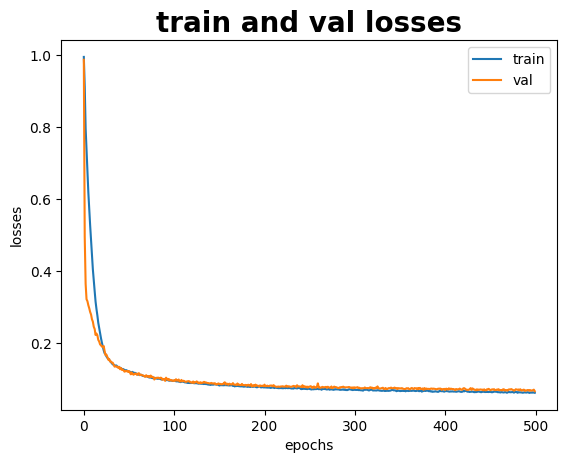

In [6]:
import matplotlib.pyplot as plt
plt.plot(train_losses[2],label ='train')
plt.plot(val_losses[2], label = 'val')
plt.title('train and val losses',fontsize =20, fontweight ='bold')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

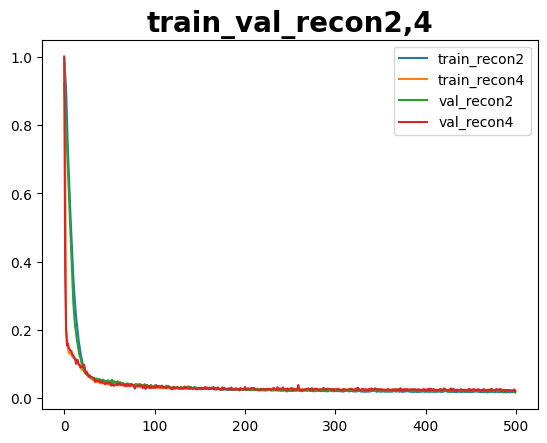

In [7]:
plt.plot(train_recones[1],label='train_recon2')
plt.plot(train_recones[3],label='train_recon4')
plt.plot(val_recones[1],label = 'val_recon2')
plt.plot(val_recones[3],label = 'val_recon4')
plt.legend()
plt.title('train_val_recon2,4',fontsize=  20,fontweight = 'bold')
plt.show()


### 훈련 초기 단계에서는 인코더가 훈련 데이터에 대한 의미있는 표현을 아직 학습하지 못했다.

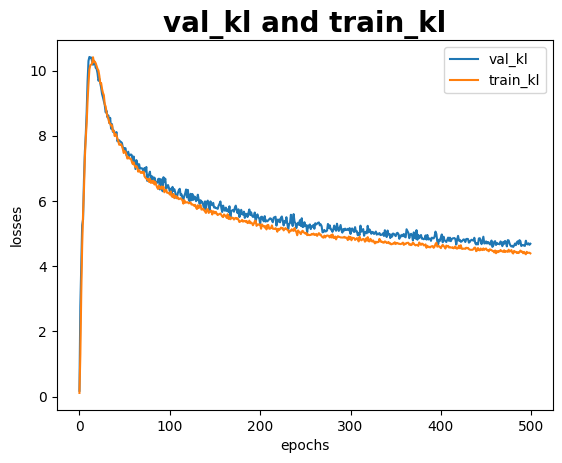

In [8]:
plt.plot(val_kl,label = 'val_kl')
plt.plot(train_kl,label='train_kl')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('losses')
plt.title('val_kl and train_kl',fontsize = 20, fontweight = 'bold')
plt.show()

## metal_features에 대해서 각각의 r^2의 값에 대해서 생각

In [19]:
model.load_state_dict(early.best_state)
model = model.to(device)
model.eval()

x_true_list = []
x_hat_list = []

with torch.no_grad():
    for x_test, c_test in test_loader:
        x_test = x_test.to(device)
        c_test = c_test.to(device)

        x_hat_test, test_mu, test_logvar = model(x_test, c_test)

        x_true_np = x_test.detach().cpu()
        x_hat_np = x_hat_test.detach().cpu()

        x_true_list.append(x_true_np)
        x_hat_list.append(x_hat_np)
        x_true = torch.cat(x_true_list,dim = 0)
        x_hat = torch.cat(x_hat_list,dim = 0)
        ss_res = torch.sum((x_true-x_hat)**2) ## 열로 해서 더한다.
        ss_tot = torch.sum((x_true-torch.mean(x_true))**2) 
        r2 = 1-ss_res/ss_tot
        print(r2.item())






0.9890013337135315
0.9888164401054382
0.9859654307365417
0.9847214221954346
0.9877952337265015
0.9856948852539062
0.9859514832496643
0.985459566116333
0.9855401515960693
0.9857758283615112
0.9856056571006775
0.9842441082000732
0.9350995421409607
0.8933756351470947
0.9002074003219604
0.9054978489875793
0.9088586568832397
0.9108306765556335
0.880940854549408


In [20]:
x_true_flat = x_true.view(-1).numpy()
x_hat_flat  = x_hat.view(-1).numpy()


In [24]:
x_true_flat.shape

(27186,)

In [23]:
r2.item()

0.880940854549408

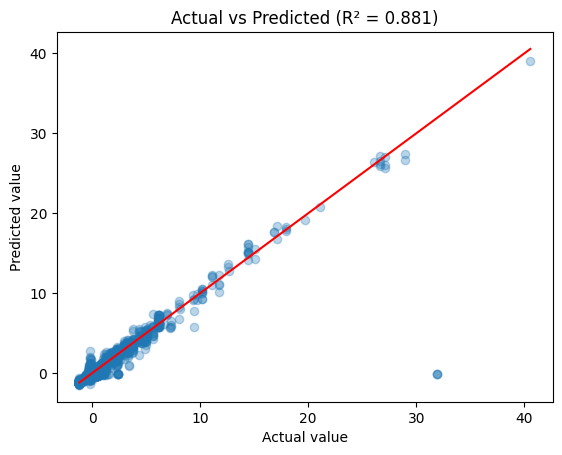

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(x_true_flat, x_hat_flat, alpha=0.3)
plt.plot(
    [x_true_flat.min(), x_true_flat.max()],
    [x_true_flat.min(), x_true_flat.max()], color = 'red'
)
plt.xlabel("Actual value")
plt.ylabel("Predicted value")
plt.title(f"Actual vs Predicted (R² = {r2.item():.3f})")
plt.show()


In [ ]:
import torch
import torch.nn.functional as F

def kl_divergence(mu, logvar):
    return 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar, dim=1)

@torch.no_grad()
def evaluate_test_elbo(model, test_loader, device):
    model.eval()

    total_elbo = 0.0
    total_n = 0

    total_recon = 0.0
    total_kl = 0.0

    for x in test_loader:
        # (x, c) 같은 형태면 여기서 맞춰주면 됨
        if isinstance(x, (list, tuple)) and len(x) == 2:
            x, c = x
            x = x.to(device)
            c = c.to(device)
            x_hat, mu, logvar = model(x, c)
        else:
            x = x.to(device)
            x_hat, mu, logvar = model(x)

        batch_size = x.size(0)

        # recon loss: MSE를 "샘플별"로 만들기 위해 feature 차원을 합산
        recon_per_sample = torch.sum((x - x_hat) ** 2, dim=1)  # (batch,)
        kl_per_sample = kl_divergence(mu, logvar)              # (batch,)

        # ELBO = E[log p(x|z)] - KL
        # Gaussian + fixed variance 가정에서 log p(x|z) ~ - recon_loss (상수항 제외)
        elbo_per_sample = -recon_per_sample - kl_per_sample

        total_elbo += torch.sum(elbo_per_sample).item()
        total_recon += torch.sum(recon_per_sample).item()
        total_kl += torch.sum(kl_per_sample).item()
        total_n += batch_size

    # 평균(샘플당)
    mean_elbo = total_elbo / total_n
    mean_recon = total_recon / total_n
    mean_kl = total_kl / total_n

    return mean_elbo, mean_recon, mean_kl


In [10]:
x_true_test_np = np.concatenate(x_true_list, axis=0)
x_hat_test_np  = np.concatenate(x_hat_list, axis=0)
x_scaler = joblib.load('./torch/x_scaler_z.pkl')
x_true_test = x_scaler.inverse_transform(x_true_test_np)
x_hat_test  = x_scaler.inverse_transform(x_hat_test_np)

print(x_true_test.shape, x_hat_test.shape)

(1182, 23) (1182, 23)


## r^2을 구하기 위해 전체 feature에 대해서 구한다
##

In [11]:
ss_res = torch.sum((x_true_test-x_hat_test)**2)
ss

TypeError: sum(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error

rmse = np.sqrt(mean_squared_error(x_true_test, x_hat_test))
mse = mean_squared_error(x_true_test,x_hat_test)
r2 = r2_score(x_true_test.flatten(),x_hat_test.flatten())
print(f'rmse: {rmse:.4f},r2: {r2:.4f}')

rmse: 0.3035,r2: 0.9688


In [ ]:
# LOSS3에 대해서 3가지 따로 보기-> recon2,recon4,kl 모니터링용 
# CASE1과 CASE3의 DIVERGENCE LOSS을 따라가는지
# Nickel_weight=1, 나머지가 작아지는 추세로 ## 해결
# KL에 대해 그래프, VAL_KL,trian_kl다 출력 
# KL의 이유에 대해서 생각하기
# 1. 0을 clipping하는 방법(비 니켈에 대해서, 효과를 자제하기위해서는 출력하는 원소에 대해서, 전체에 대한 mse에 대해서 니켈에 대해서, 
# unique, 머신러닝내에서 최종적으로 softmax로 해서 제거하기)--> clipping: 3개가 넘게 예측을 하면 잘못된 규제를 한다. 
# 2.0초과하는 원소의 값 세가지( classification모델도 따로, cut_off로 진행, )


In [ ]:
## Ni 함량에 대해서 고민하기 
## Ni 피처의 유무 따져보기()

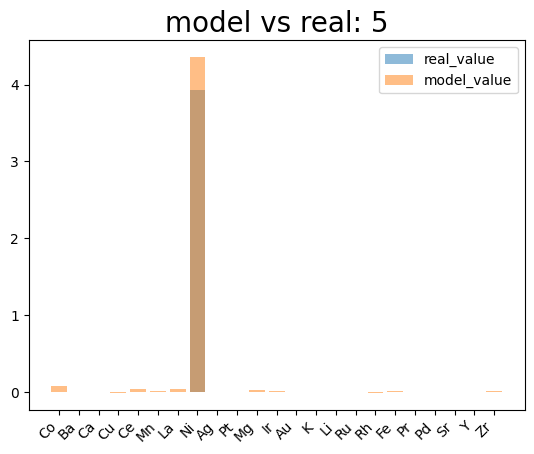

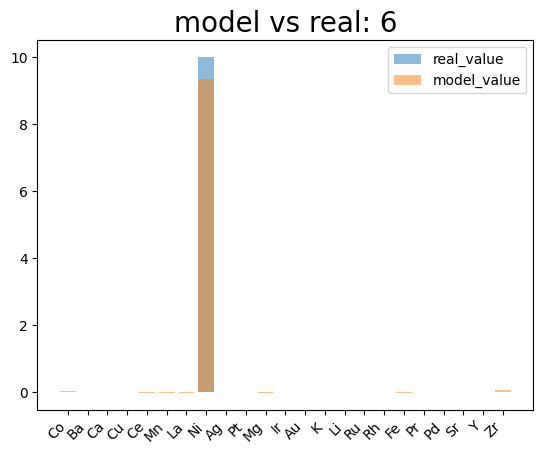

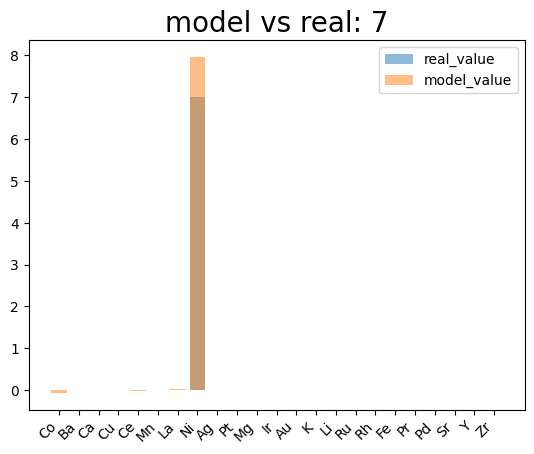

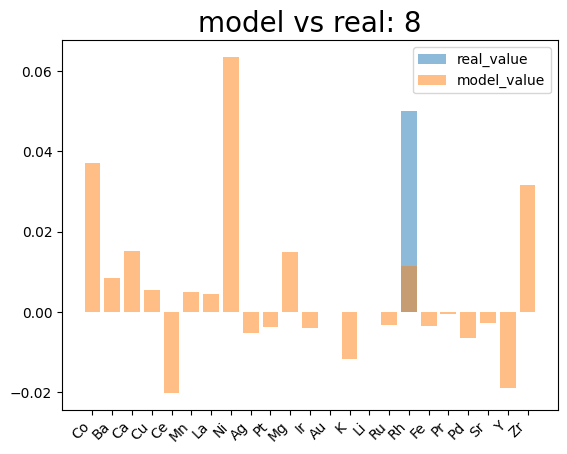

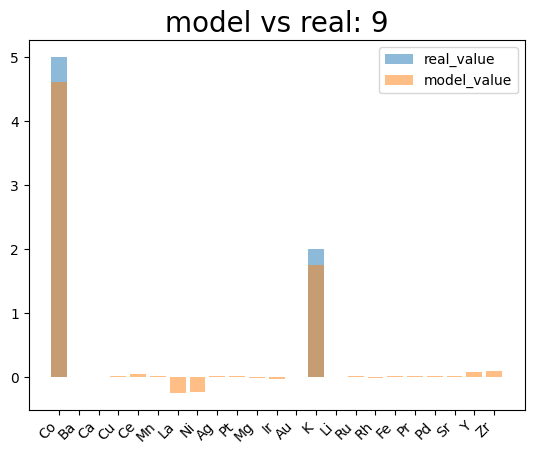

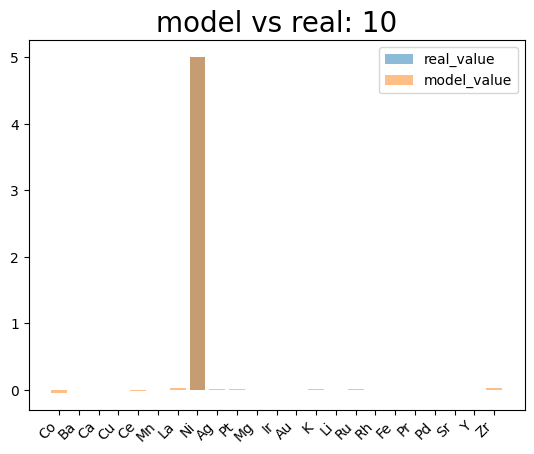

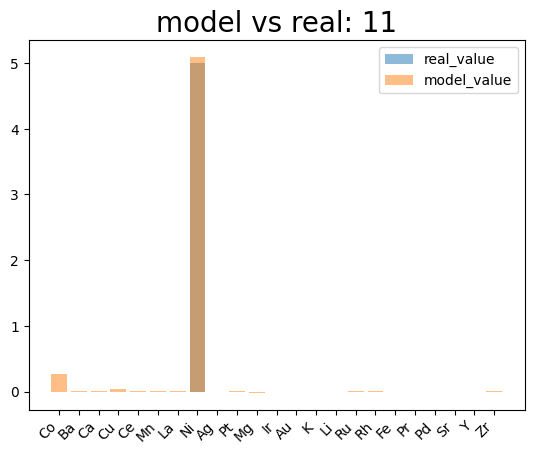

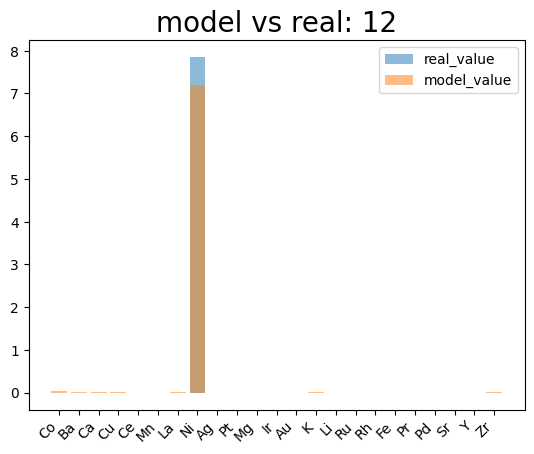

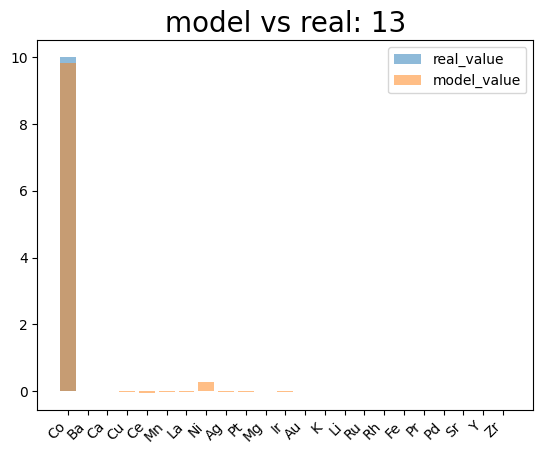

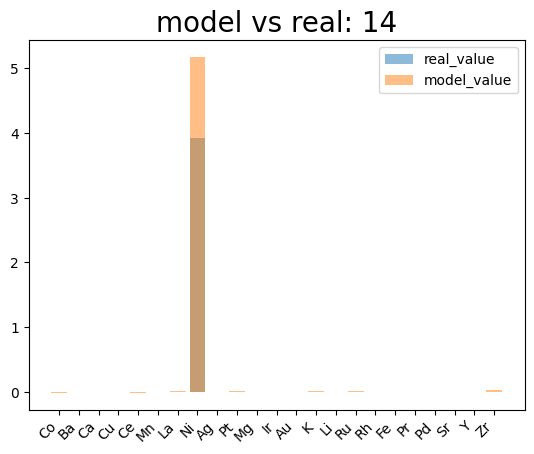

In [ ]:
df = pd.read_csv('211210-DRM-total.csv')
metal_columns = df.iloc[:,2:25].columns
for i in range(5,15):
    plt.bar(metal_columns, x_true_test[i],label = 'real_value',alpha = 0.5)
    plt.bar(metal_columns,x_hat_test[i],label = 'model_value', alpha=0.5)
    plt.xticks(rotation=45,ha='right')
    plt.title(f'model vs real: {i}',fontsize = 20)
    plt.legend()
    plt.show()